[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1v3YiPuDstFN9MV1BhfQ9VEgpMV3PIOVu?usp=sharing)

Source: https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/Introduction_to_RNN_Time_Series.ipynb

#### Import keras

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(0)

# Simple Architectures

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In time series forecasting we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [2]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [3]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


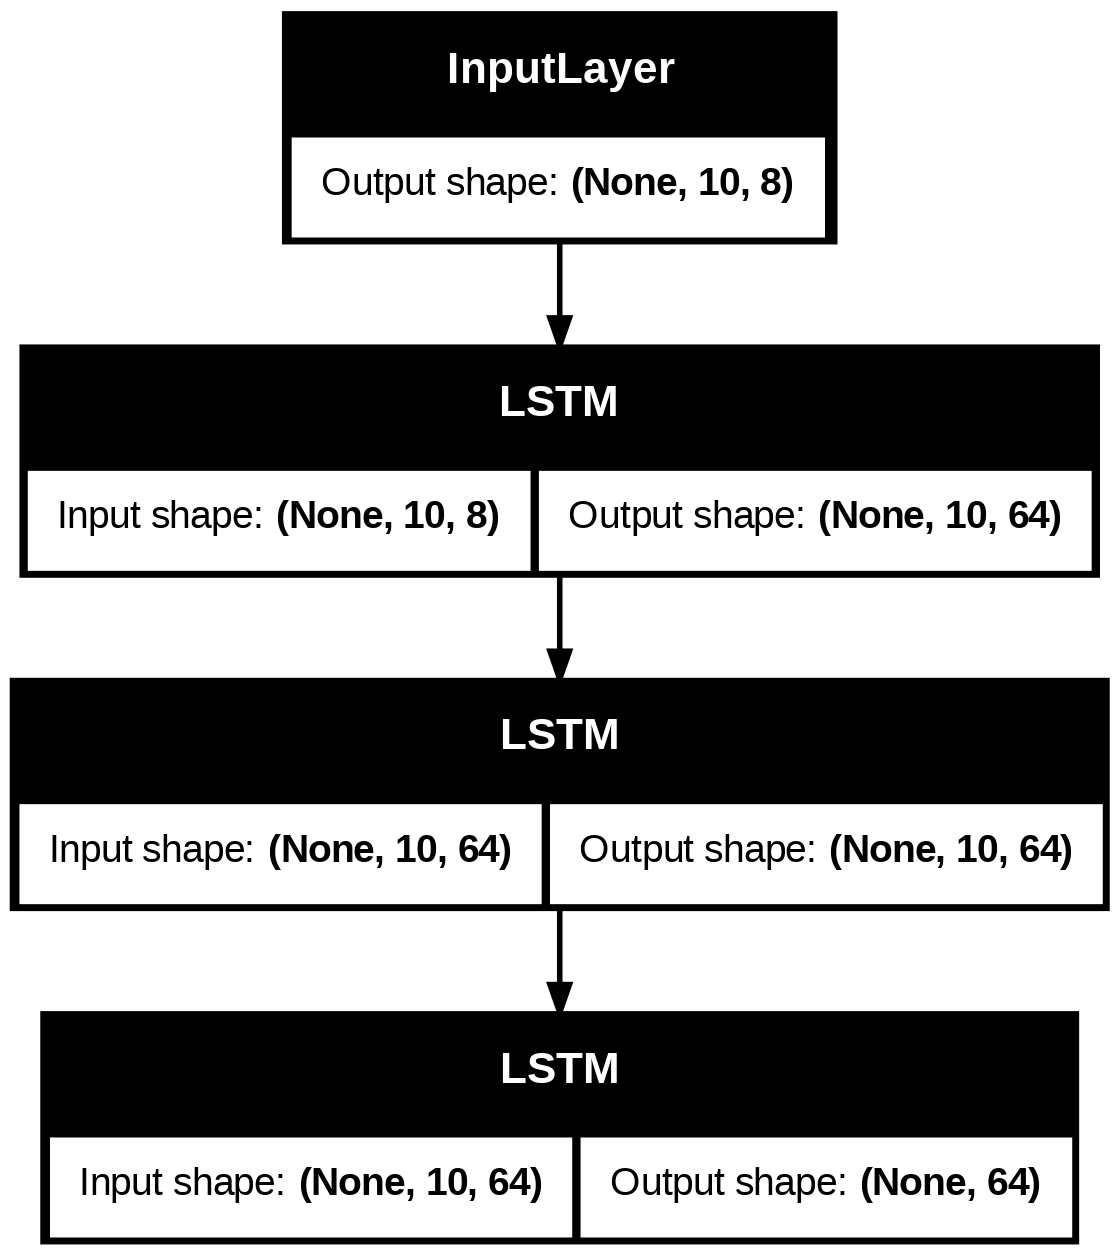

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

# Time Series Data Processing

## Sliding Windows

A sliding window is a technique used to create input-output pairs from time series data. It moves a fixed-size window over the time series data to extract subsequences as input features and the corresponding next value(s) as the target(s). The window size determines the number of past time steps to use as input features, and the horizon determines the number of future time steps to predict.


<img src="https://i.ibb.co/5nvJQB4/split-window.png" alt="cnn" border="0">

We will define two `create_windows` functions, one for `tf.data.Dataset` and another for NumPy, to create input-output pairs from the time series data using sliding windows.


For example if  `data = [0,1,2,3,4,5,6]` :

If we have `window_size=3`, and `horizon=2`, we use **windows of size 3** for predicting **2 steps ahead**.

we are going to use `[0,1,2] (length=window_size=3)` to predict `4`,

We need too create a training data like
```python
[0,1,2], 4
[1,2,3], 5
[2,3,4], 6
```


In [5]:
def create_windows_np(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray): Time series data with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Shuffle the windows or not.

    Returns:
    tuple: A tuple containing the input-output pairs (windows, targets) as NumPy arrays.
    """

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


In [6]:
X_trial, y_trial = create_windows_np(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)
for ind in range(len(y_trial)):
    print(X_trial[ind, :], y_trial[ind])

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


In [7]:
def create_windows_tf(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (np.ndarray): Time series data with with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (window[:window_size], window[-1]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

ts_dataset = create_windows_tf(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)

for window, target in ts_dataset:
    print(window.numpy(), target.numpy())

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


# Simple univariate time series forecasting with RNN

We will use a sine wave as our example time series data. We will generate 1000 data points with a step of 0.1.

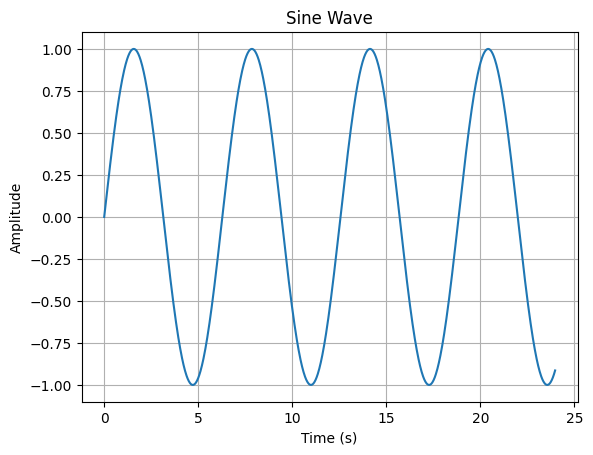

In [8]:
# Generate sine wave data
t = np.arange(0, 24, 0.02)
y = np.sin(t)

# Plot the sine wave
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sine Wave')
plt.grid(True)
plt.show()

In [9]:
# train test split
train_size = int(len(y) * 0.8)
ts_train, ts_test = y[:train_size], y[train_size:]
print(ts_test.shape)

(240,)


In [10]:
window_size = 10
horizon = 10
X_train, y_train = create_windows_np(ts_train, window_size, horizon=2, shuffle=False)
X_test, y_test = create_windows_np(ts_test, window_size, horizon=2, shuffle=False)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (949, 10)
Test shape: (229, 10)


In [11]:
inputs_shape = (window_size, 1)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, 1))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=7,
    validation_data=(X_test, y_test)
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.3311 - val_loss: 0.2440
Epoch 2/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1532 - val_loss: 0.0739
Epoch 3/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0391 - val_loss: 0.0138
Epoch 4/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 5/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 6/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 7/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - val_loss: 0.0064


In [12]:
# Use the trained RNN model to make predictions on the test data.
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


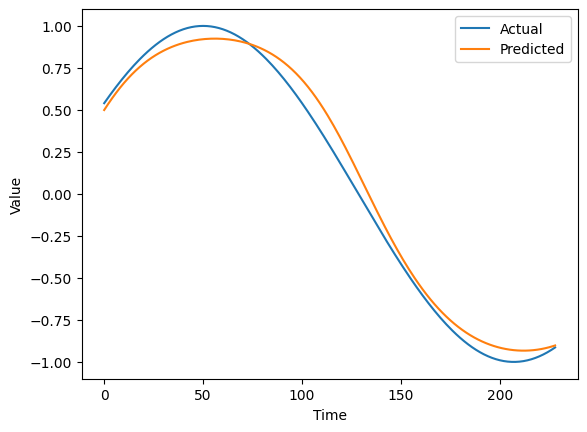

In [13]:
# visualize the actual vs. predicted values.
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Simple multivariate time series forecasting with RNNs

In [14]:
import pandas as pd


def create_windows_multivariate_np(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray or pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tuple: A tuple containing the input-output pairs (X, y) as NumPy arrays.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size+horizon-1, target_col_idx])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


def create_windows_multivariate_tf(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (
        window[:window_size], window[-1, target_col_idx]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

In [15]:
# Generate synthetic multivariate time series data
t = np.arange(0, 24, 0.01)
y1 = np.sin(0.1 * t)
y2 = 0.5 * np.sin(0.2 * t)
data = np.vstack((y1, y2)).T
print(data.shape)

(2400, 2)


In [16]:
# train test split
train_size = int(data.shape[0] * 0.8)
ts_train, ts_test = data[:train_size], data[train_size:]
print(ts_test.shape)

(480, 2)


In [17]:
window_size = 10
horizon = 10


train_ds = create_windows_multivariate_tf(
    ts_train, window_size, horizon, target_col_idx=0, shuffle=False)

test_ds = create_windows_multivariate_tf(
    ts_test, window_size, horizon, target_col_idx=0, shuffle=False)

train_ds = train_ds.batch(64)
test_ds = test_ds.batch(100)

In [18]:
for window, target in train_ds:
    print(window.numpy().shape, target.numpy().shape)
    break

(64, 10, 2) (64,)


In [19]:
num_features = 2 # (y1, y2)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, num_features))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    train_ds,
    epochs=12,
    validation_data=test_ds
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8)                   │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
     28/Unknown 2s 18ms/step - loss: 0.2593

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2832 - val_loss: 0.5087
Epoch 2/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1172 - val_loss: 0.2991
Epoch 3/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0500 - val_loss: 0.1408
Epoch 4/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0524 - val_loss: 0.0575
Epoch 5/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0758 - val_loss: 0.0315
Epoch 6/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0692 - val_loss: 0.0197
Epoch 7/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0548 - val_loss: 0.0104
Epoch 8/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0425 - val_loss: 0.0042
Epoch 9/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0317 - val_loss: 0.0010
Epoch 10/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0227 - val_loss: 7.3995e-05
Epoch 11/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - val_loss: 3.0411e-05
Epoch 12/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


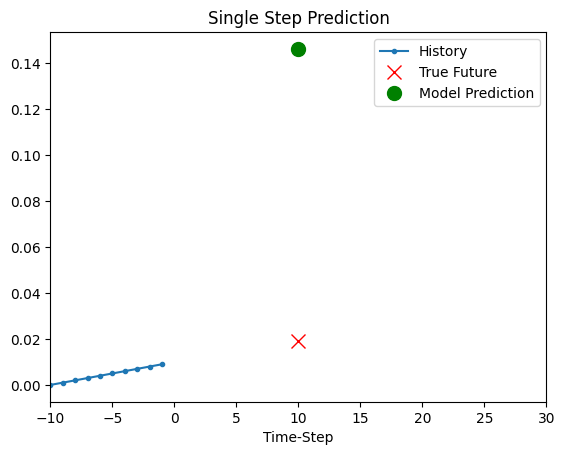

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


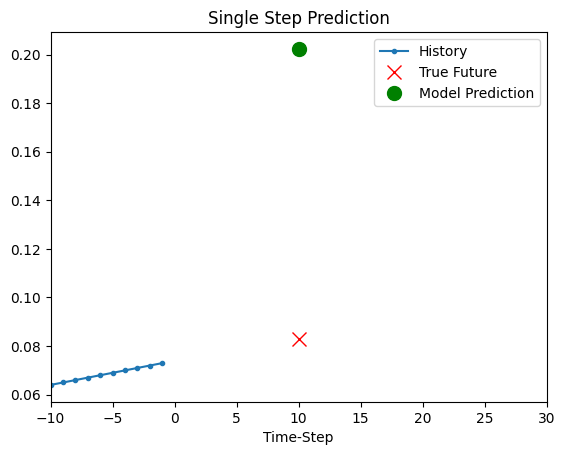

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


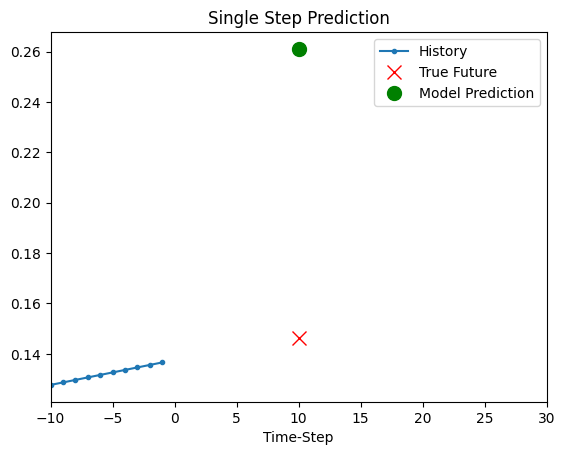

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


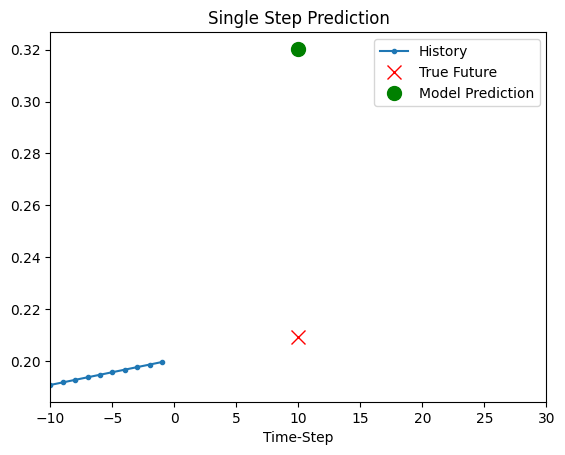

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


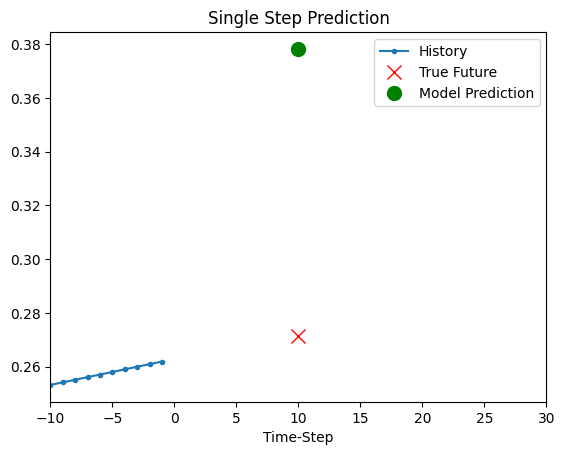

In [20]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in train_ds.take(5):
    x_in = x.numpy()
    y_in = y.numpy().flatten()
    pred = model.predict(x)
    show_plot(
        [x_in[0,:, 0], y_in[0], pred.flatten()[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


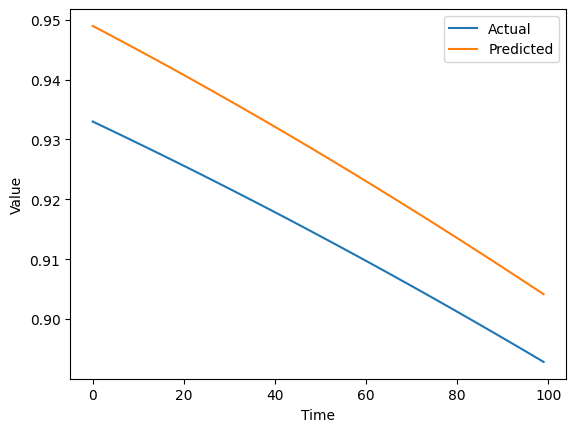

batch:  1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


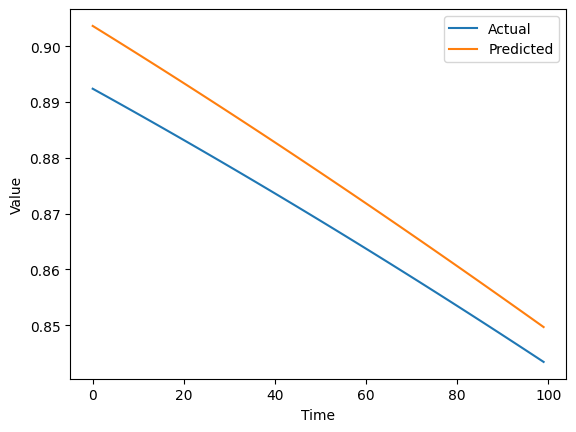

batch:  2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


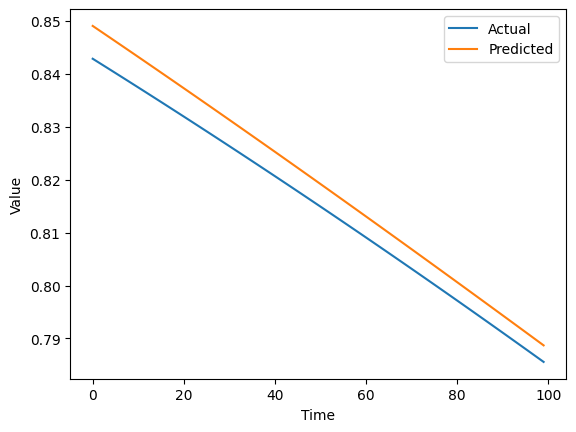

In [21]:
for i, (x, y) in enumerate(test_ds):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [22]:
from zipfile import ZipFile
import os


uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path, parse_dates =['Date Time'])
df.head()

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

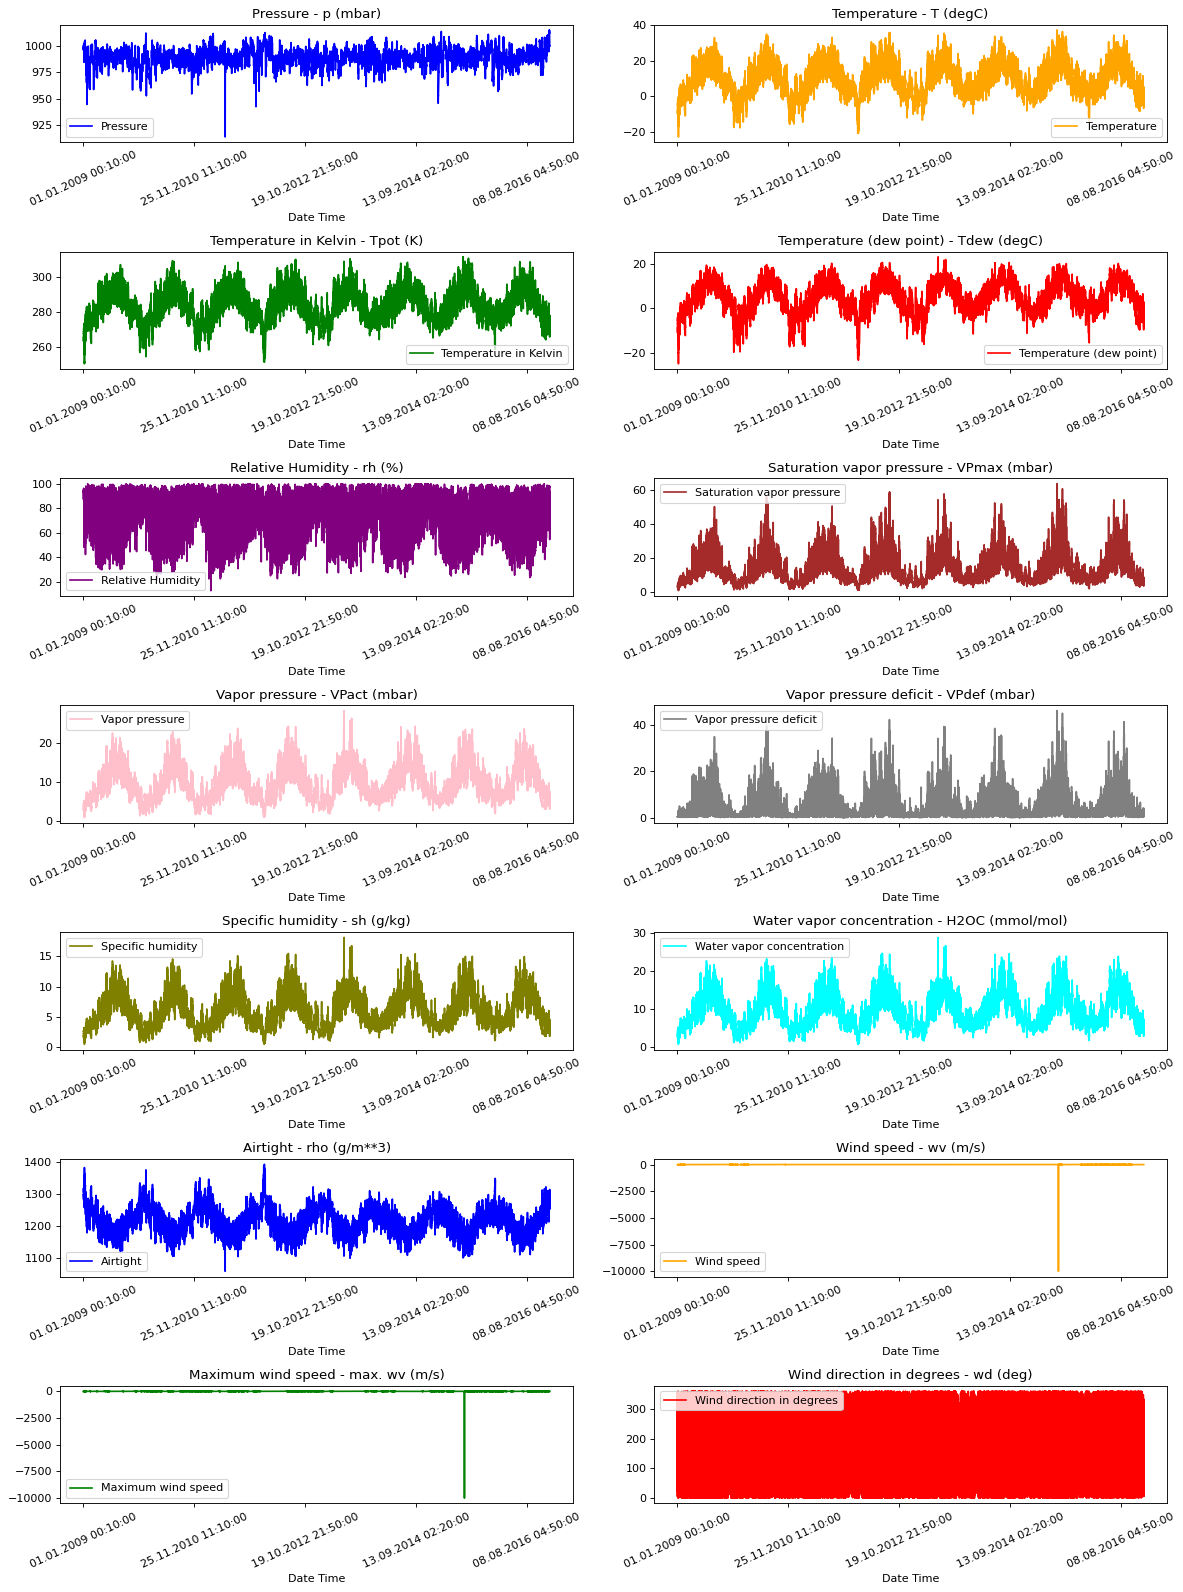

In [23]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

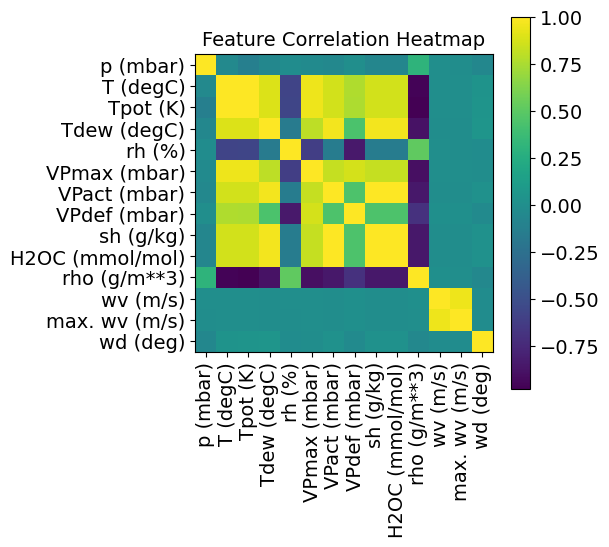

In [24]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

df_corr = df.drop(columns=["Date Time"])
show_heatmap(df_corr)

In [25]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

### Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [26]:
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst=True)
df = df.set_index('Date Time')
## resample by the mean of hour values
df = df.resample('1h').mean().fillna(method='ffill')
df.head()

<ipython-input-26-8bfc6a172fb2>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('1h').mean().fillna(method='ffill')


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


In [27]:
#Use only important features
df_0 = df.copy()
df = df[selected_features].copy()

In [28]:
df.values.shape

(70129, 9)

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [29]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.290000,0.670000,150.093333


### Training and validation datasets



In [30]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12

batch_size = 128

columns = df.columns
# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 9)
Target shape: (128,)


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [31]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Training

#### Normalization layer
We can normalize the features with [Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization).

```python
tf.keras.layers.Normalization(
    axis=-1, dtype=None, mean=None, variance=None, **kwargs
)
```

```python
norm = tf.keras.layers.Normalization()
norm.adapt(dataset_train.map(lambda x, y: x))

```



`adapt` computes mean and std of the train data and store them as the layer's weights. `adapt`
 should be called before fit, evaluate, or predict.



In [32]:
norm = tf.keras.layers.Normalization(
    axis=-1, dtype=None, mean=None, variance=None
)
norm.adapt(dataset_train.map(lambda x, y: x))

print('Unnormalized row: ', df.iloc[:1].values)
print('Normalized row: ', norm(df.iloc[:1]))
print('Normalized df, mean row: ',norm(df.values).numpy().mean(1))
print('Normalized df, std row: ',np.std(norm(df.values).numpy(), 1))

Unnormalized row:  [[ 9.965280e+02 -8.304000e+00  3.260000e+00  2.020000e-01  1.910000e+00
   1.309196e+03  5.200000e-01  1.002000e+00  1.744600e+02]]
Normalized row:  tf.Tensor(
[[[ 0.9488587  -2.0142398  -1.3145658  -0.7907288  -1.4998453
    2.2535245  -1.1247866  -1.1621995   0.01345278]]], shape=(1, 1, 9), dtype=float32)
Normalized df, mean row:  [[ 0.06744269  0.03871635  0.02783801  0.00901053  0.03926668 -0.02186222
  -0.3116576  -0.22941802  0.01771252]]
Normalized df, std row:  [[ 1.0075998   0.97279596  1.0055248   1.0171733   0.9927365   0.97563714
  42.94973    30.316542    0.9848095 ]]


#### Create the model

In [33]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


In [34]:
num_features =  9
inputs_shape = (window_size, num_features)

inputs = keras.layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
rnn_out = keras.layers.SimpleRNN(32)(inputs_norm)
outputs = keras.layers.Dense(1)(rnn_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 6, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 6, 9)                │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,396 (5.46 KB)

 Trainable params: 1,377 (5.38 KB)

 Non-trainable params: 19 (80.00 B)

We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [35]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    384/Unknown 4s 4ms/step - loss: 110.7550

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 36.90725, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 110.6526 - val_loss: 36.9072
Epoch 2/25
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.0983
Epoch 2: val_loss improved from 36.90725 to 24.20055, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 30.0845 - val_loss: 24.2005
Epoch 3/25
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.3673
Epoch 3: val_loss improved from 24.20055 to 21.51228, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 22.3504 - val_loss: 21.5123
Epoch 4/25
370/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9941
Epoch 4: val_loss improved from 21.51228 to 18.55282, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 18.9860 - val_loss: 18.5528
Epoch 5/25
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.8598
Epoch 5: val_loss improved fro

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


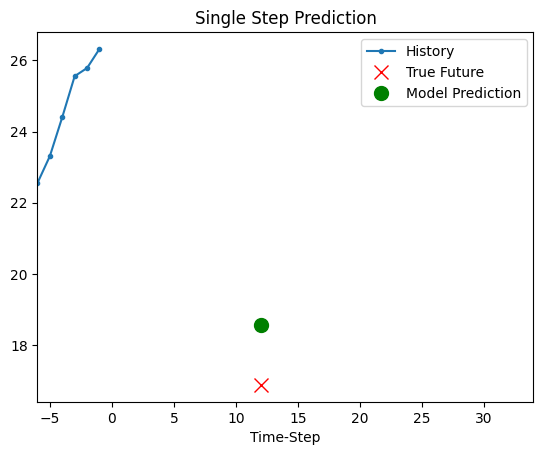

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


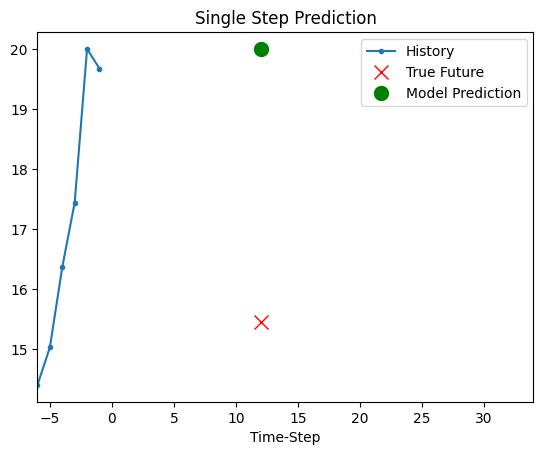

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


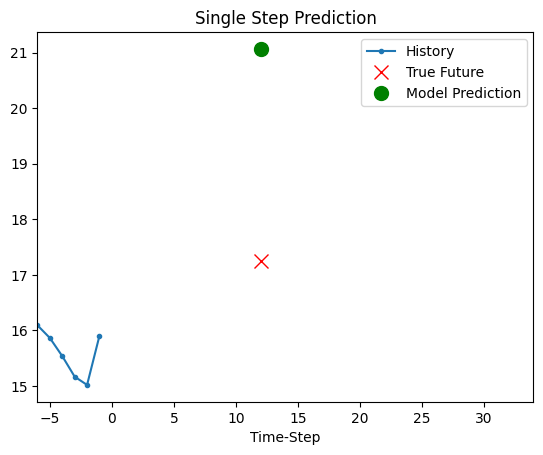

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


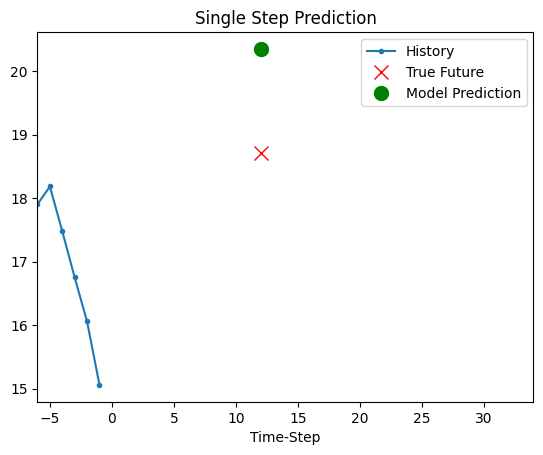

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


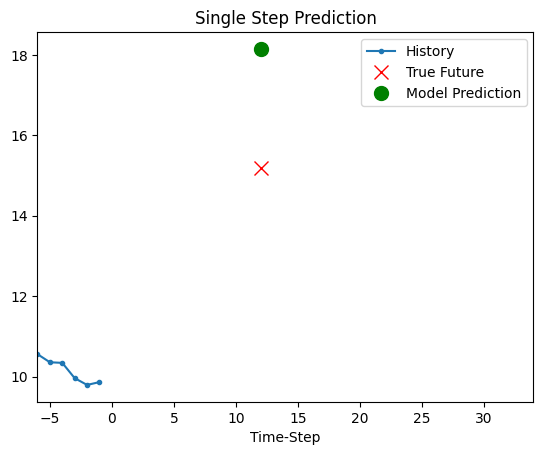

In [36]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


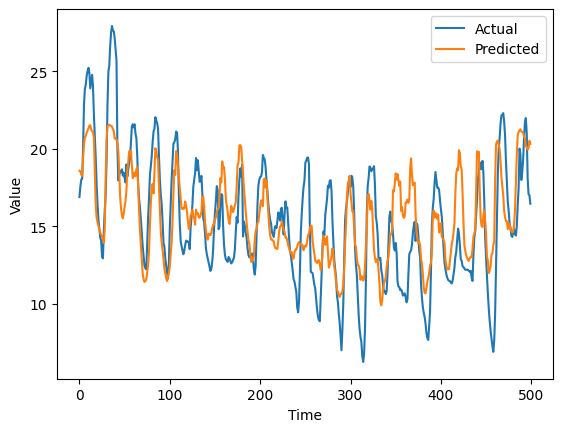

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


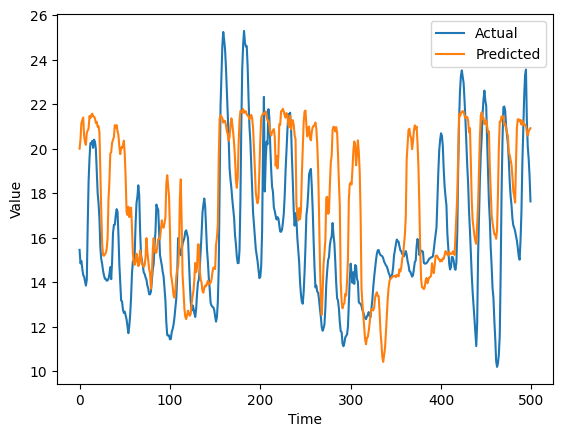

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


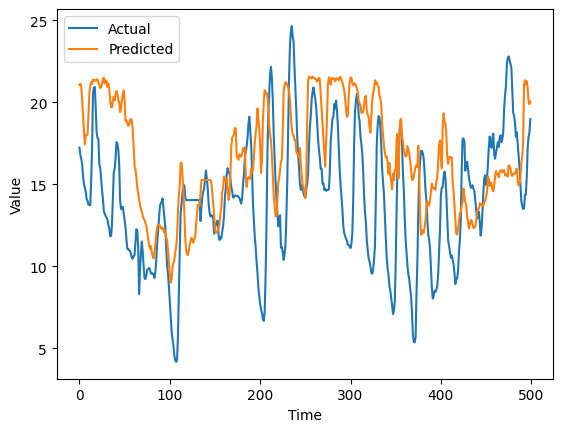

In [37]:

for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

#### Question 1:  Change the `keras.layers.SimpleRNN` layer to `keras.layers.LSTM` and to `keras.layers.GRU` and compare the results
You can also set the `recurrent_dropout` parameter

```python
tf.keras.layers.x(
    units,
    dropout=0.0,
    recurrent_dropout=0.0)
```

In [39]:
num_features = 9
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
lstm_out = layers.GRU(64)(inputs_norm)

outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [40]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 89.1672 - val_loss: 20.8521
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 20.2058 - val_loss: 18.6165
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 17.6994 - val_loss: 17.8133
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 15.2260 - val_loss: 16.1261
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 15.5014 - val_loss: 16.6606
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 15.8747 - val_loss: 15.7401
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.4407 - val_loss: 15.1886
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.9855 - val_loss: 14.6975
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13.9783 - val_loss: 15.7109
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13.2447 - val_loss: 14.8104
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.9250 - val_loss: 16.0516


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


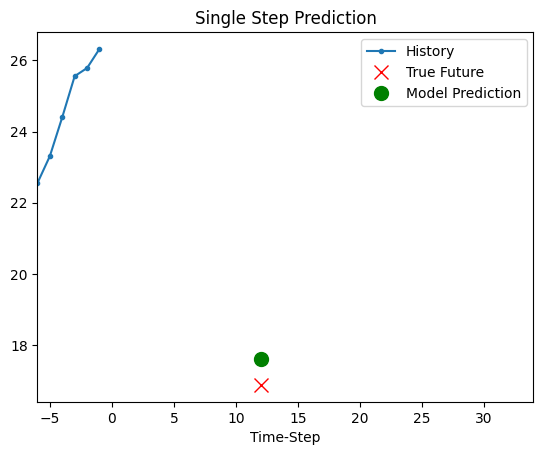

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


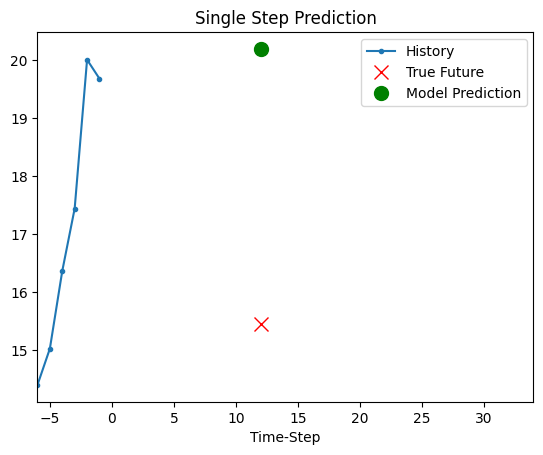

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


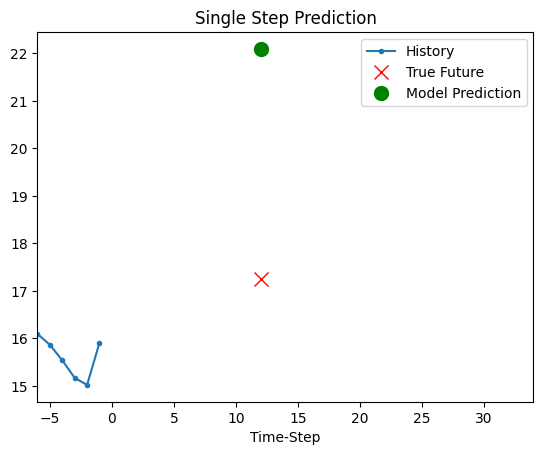

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


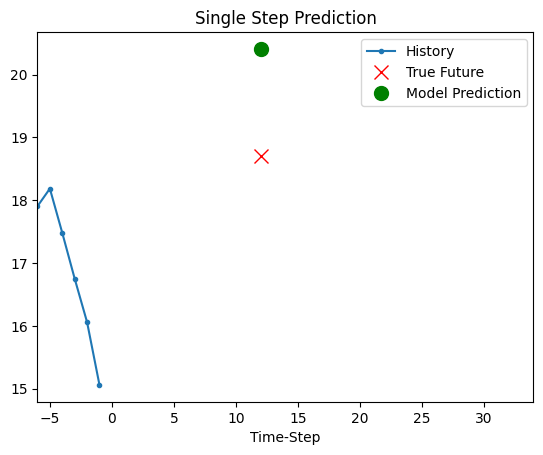

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


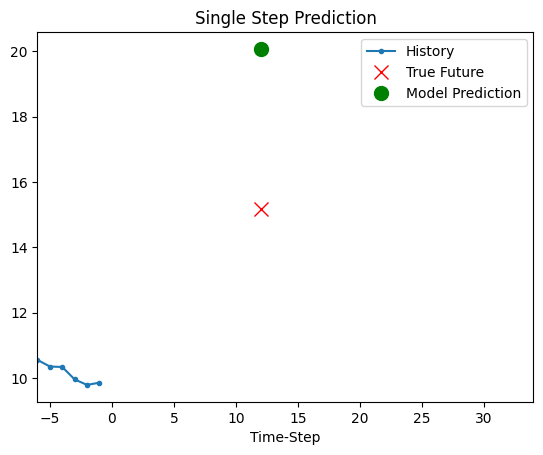

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


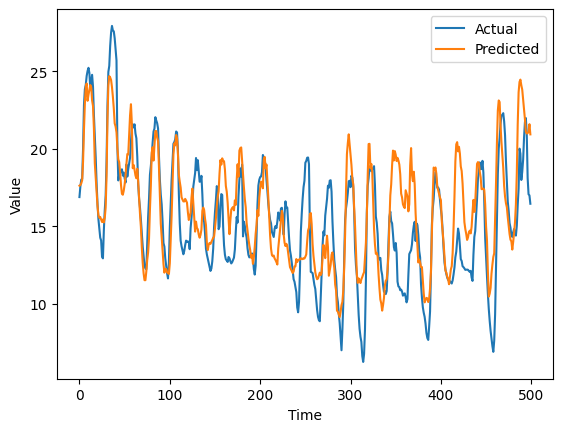

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


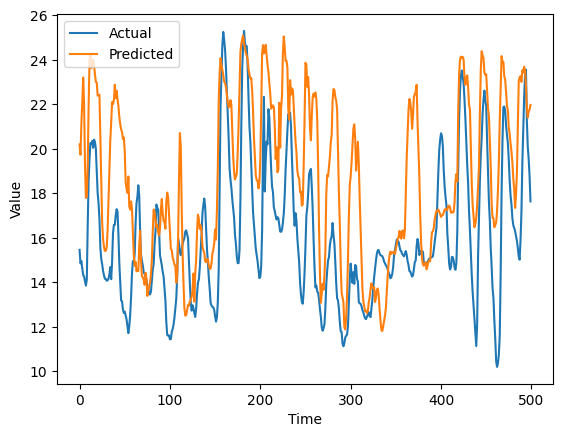

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


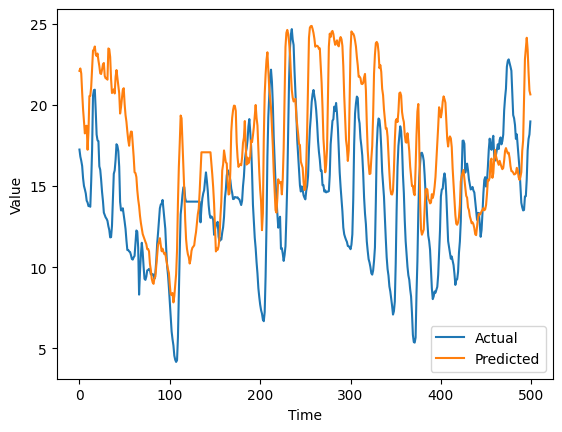

In [41]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Feature Engineering

Wind velocity
One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [42]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
df['wv (m/s)'] = wv

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['max. wv (m/s)'] = max_wv


But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [43]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:


Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [44]:
from datetime import datetime
timestamp_s = df.index.map(datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [45]:
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [46]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [47]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 15)
Target shape: (128,)


In [48]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Question 2:  Use the same model as before and compare the results


In [49]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [50]:
num_features = 15
inputs_shape = (window_size, num_features)

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
## complete the code
lstm_out = layers.GRU(64)(inputs_norm)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [51]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
    374/Unknown 3s 4ms/step - loss: 65.9979

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 65.1496 - val_loss: 12.0067
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.7644 - val_loss: 8.5255
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.4552 - val_loss: 7.5738
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2259 - val_loss: 7.6389
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7875 - val_loss: 7.0454
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.8071 - val_loss: 6.6257
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.8715 - val_loss: 6.3170
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4797 - val_loss: 6.5945
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2848 - val_loss: 6.3318
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.1350 - val_loss: 6.2806
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1056 - val_loss: 6.0930
Epoch 12/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


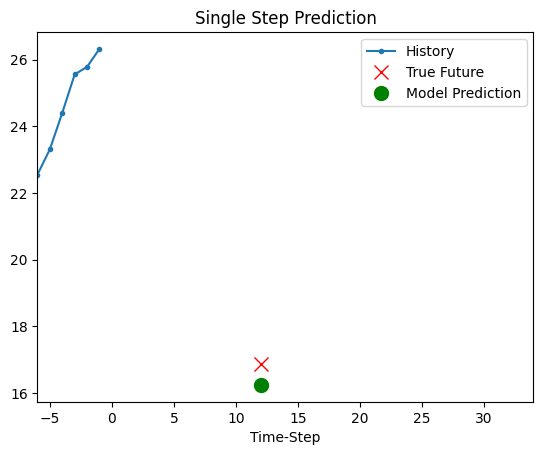

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


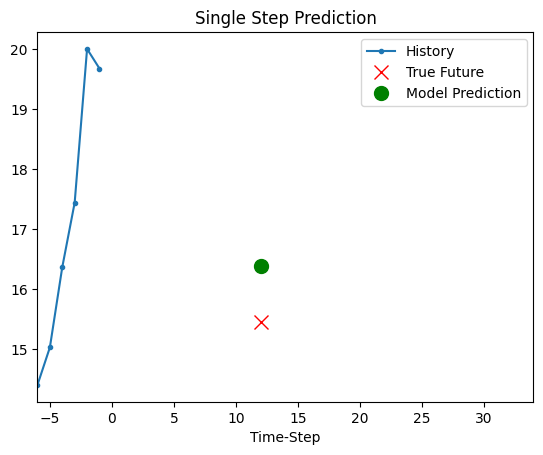

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


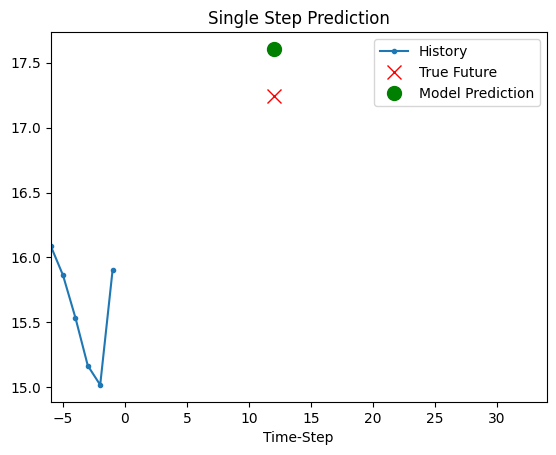

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


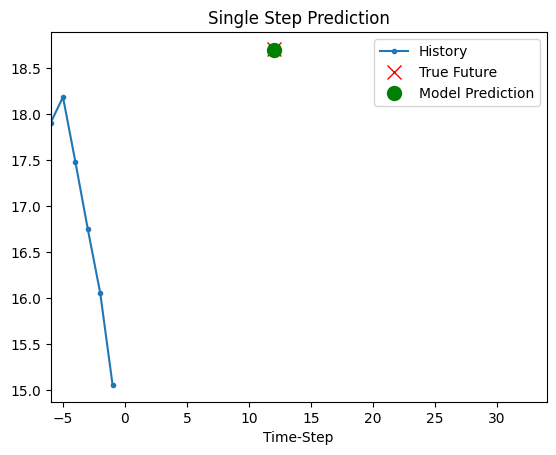

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


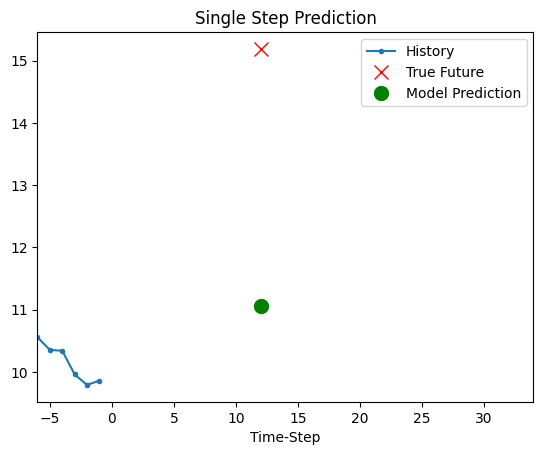

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


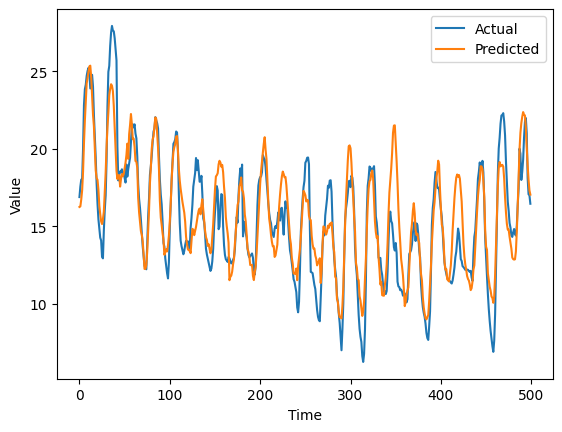

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


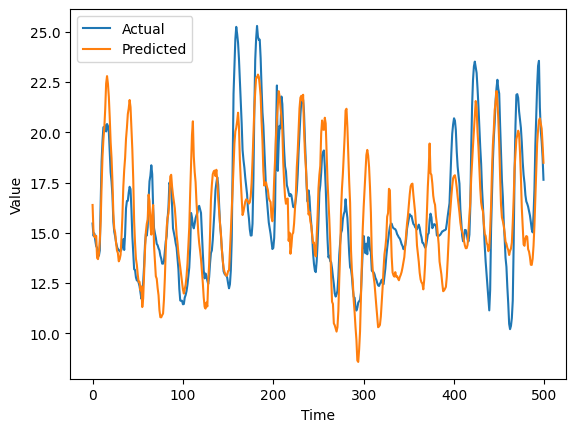

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


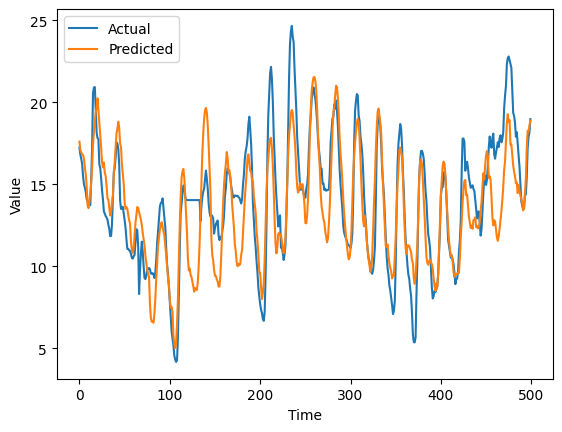

In [52]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 3:  Create a deep model stacking two recurrent layers

In [53]:
num_features = 15
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

## complete the code
l_1 = keras.layers.LSTM(64, return_sequences=True)(inputs_norm)
l_2 = keras.layers.LSTM(64, return_sequences=False)(l_1)

outputs = keras.layers.Dense(1)(l_2)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [54]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 53.9835 - val_loss: 11.6668
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.3205 - val_loss: 8.2944
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.0851 - val_loss: 7.3863
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.3609 - val_loss: 7.8069
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.7461 - val_loss: 7.5232
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.8354 - val_loss: 7.3477
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.4551 - val_loss: 7.0118
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.5010 - val_loss: 6.5684
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.0769 - val_loss: 7.3024
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.4184 - val_loss: 6.4092
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.2435 - val_loss: 6.6392
Epoch 12/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/st

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


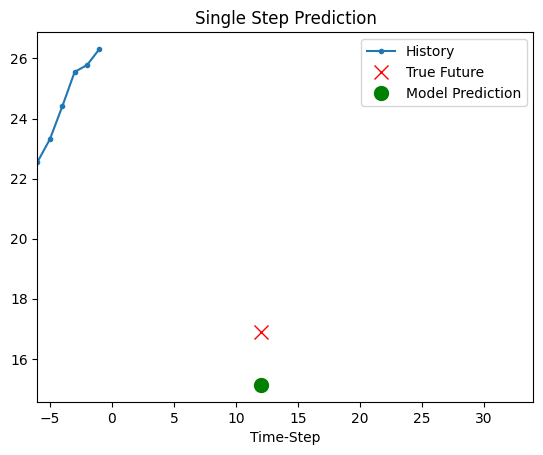

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


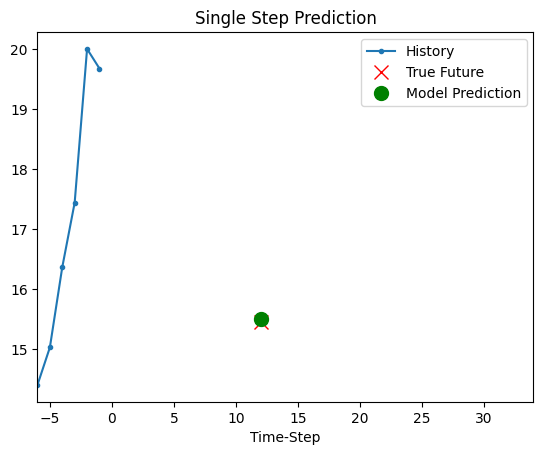

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


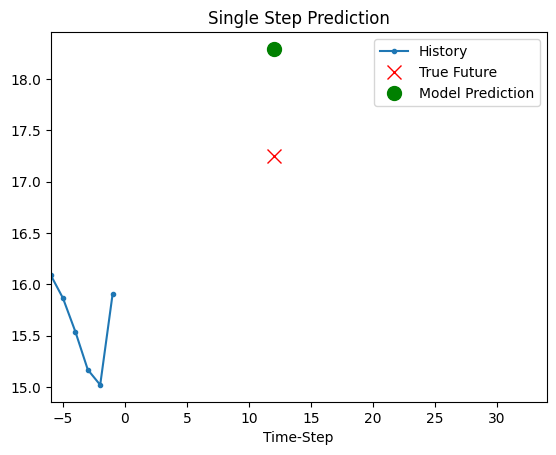

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


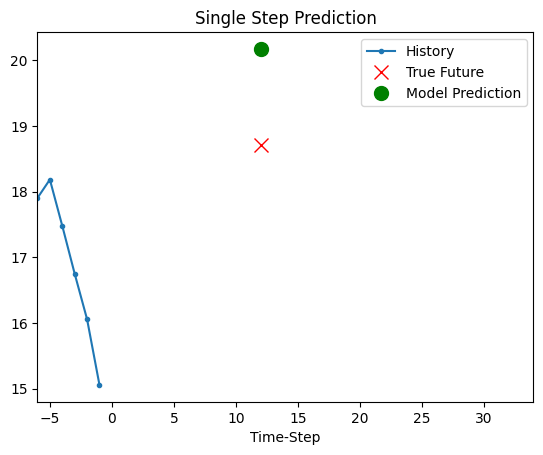

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


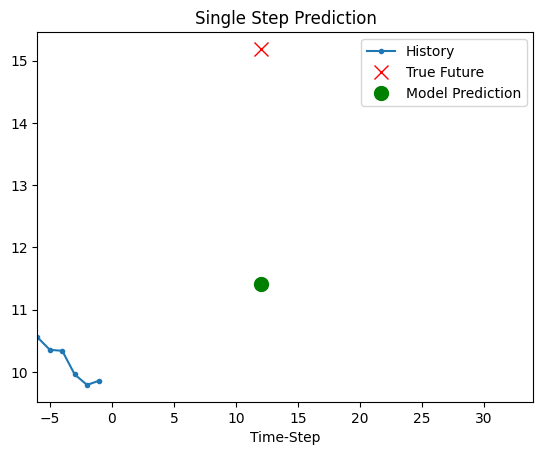

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


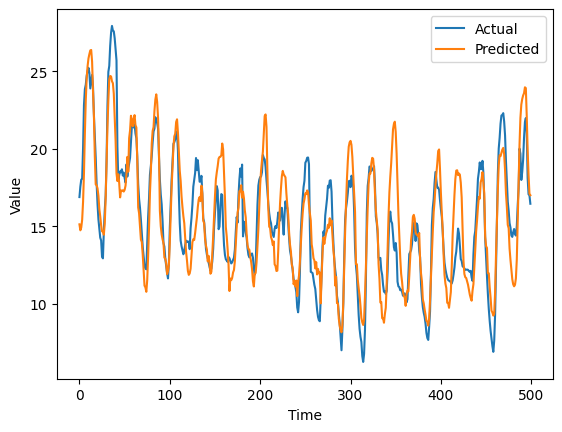

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


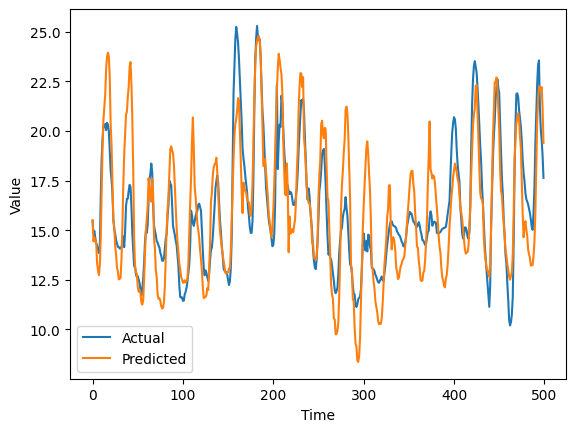

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


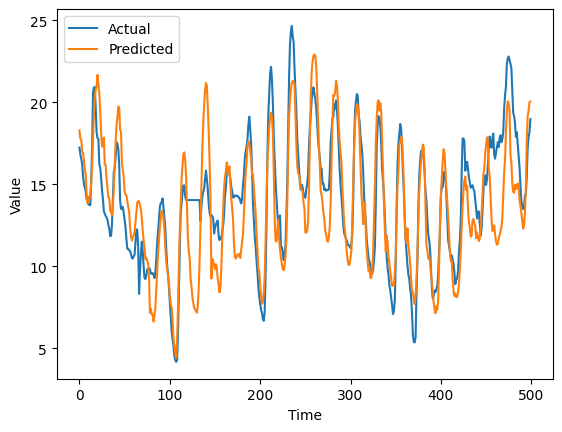

In [55]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 5:  Obtain a good model for predicting the temperature in 24h

Try different architectures and different values for `window_size`

In [56]:
horizon = 24

In [57]:
## previous hours to consider
window_size = 48

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 48, 15)
Target shape: (128,)


In [58]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [60]:
inputs = layers.Input(shape=(window_size, num_features))
inputs_norm = norm(inputs)


l_1 = keras.layers.GRU(128, return_sequences=False)(inputs_norm)
l_1 = layers.Dropout(0.4)(l_1)
outputs = keras.layers.Dense(1)(l_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [61]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    381/Unknown 4s 5ms/step - loss: 65.5411
Epoch 1: val_loss improved from inf to 11.17144, saving model to model_checkpoint.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 65.2921 - val_loss: 11.1714
Epoch 2/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.9341
Epoch 2: val_loss improved from 11.17144 to 9.99540, saving model to model_checkpoint.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 11.9341 - val_loss: 9.9954
Epoch 3/25
375/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4581
Epoch 3: val_loss improved from 9.99540 to 9.04222, saving model to model_checkpoint.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 11.4414 - val_loss: 9.0422
Epoch 4/25
377/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.3108
Epoch 4: val_loss did not improve from 9.04222
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 10.3157 - val_loss: 9.4730
Epoch 5/25
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.3699
Epoch 5: val_loss improved from 9.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


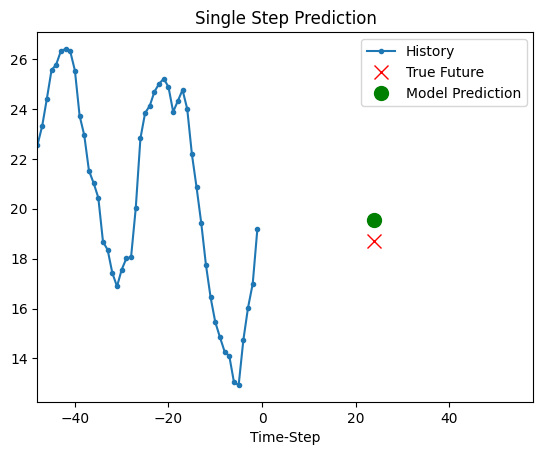

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


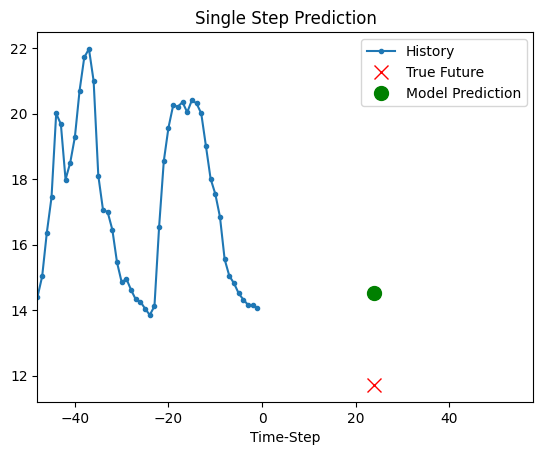

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


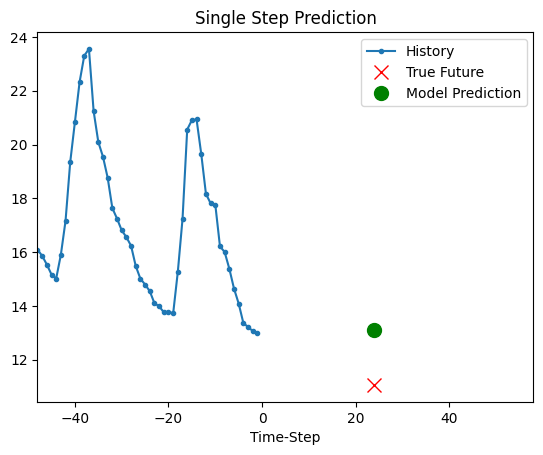

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


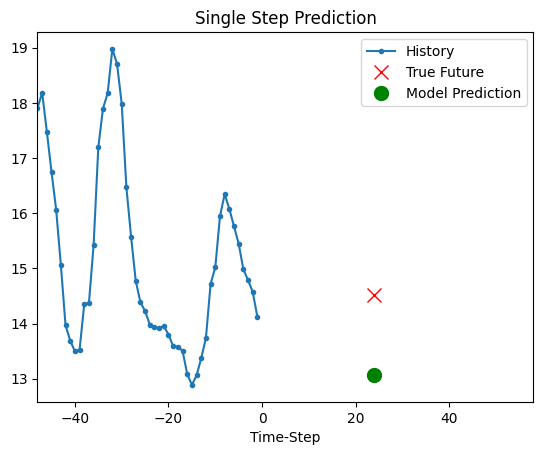

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


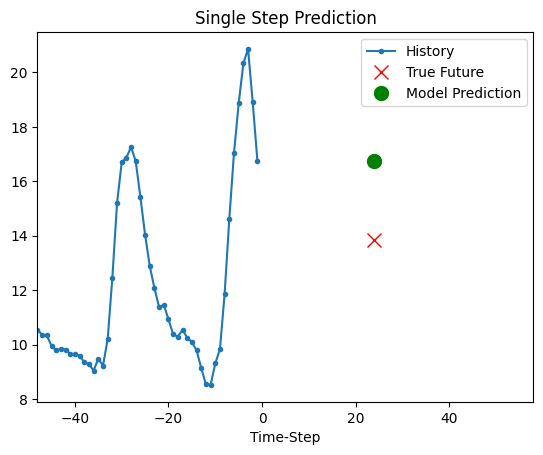

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


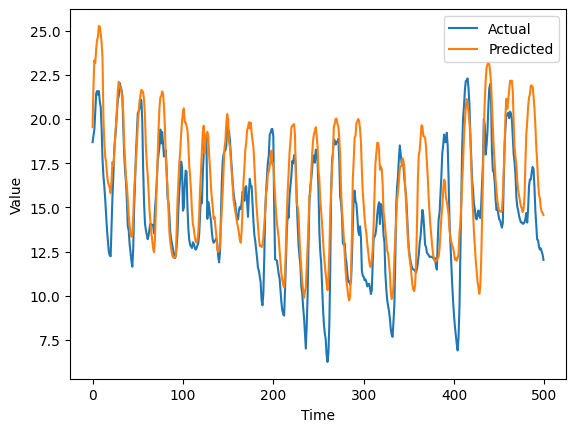

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


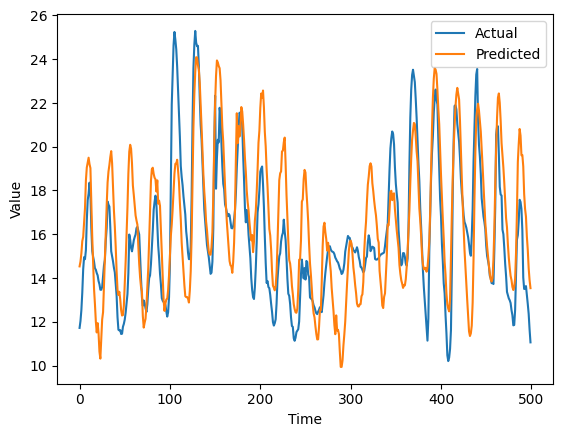

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


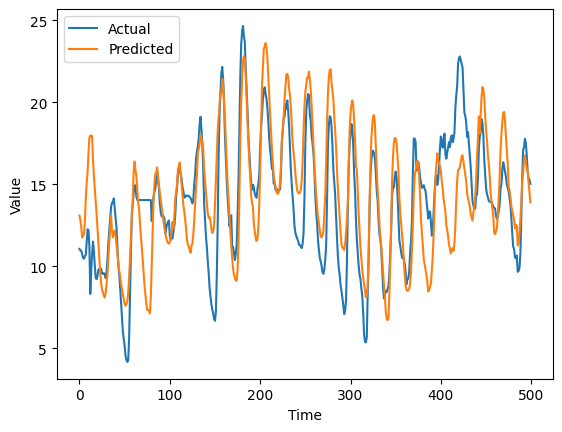

In [62]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()